In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_2/integral_1

# def calculate_IPR(intensity_array, x1):
#     x1 = np.asarray(x1)
#     values = intensity_array

#     # Reshape x1 to broadcast over columns (axis=1)
#     x1 = x1[:, np.newaxis]  

#     norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
#     mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
#     mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
#     sigma = np.sqrt(mean_sq - mean**2)
#     return sigma



# Define the colors: Blue -> White -> Yellow -> Green -> Red
colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
    
    # Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)


In [11]:
data_intensities_exit = []

with h5py.File(rf"G:\2D SHU Antennas Freq\data\20250505 2D Beam Spreading Antennas Freq analysis\intensities_exit.h5", 'r') as h5f:
    data_intensities_exit = {
            "data_field_intensities": h5f["data_field_intensities"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "x":np.array(h5f["x"]),
            "f":np.array(h5f["f"]),
        
        }


In [12]:
(data_intensities_exit["size"])

array([7])

Average Intensity IPR

In [13]:
average_xis_exit_1 = np.zeros(shape=(12,16,150))
data_exit = np.copy(data_intensities_exit["data_field_intensities"])
for i,chi in enumerate(data_exit):
    for j,length in enumerate(chi): 
        intensities =[]
        for k,sample in enumerate(length):
            max_value = np.max(sample)
            sample_normalized = sample/max_value
            sample_normalized[sample_normalized <= 1e-5]=0
            intensities.append(sample_normalized)

        average_intensity = np.mean(intensities,axis=0)
        average_xis_exit_1[i-1,j]=1/calculate_IPR(average_intensity,data_intensities_exit["x"])

average_xis_exit_1[np.isnan(average_xis_exit_1)] = 0
average_xis_exit_1[np.isinf(average_xis_exit_1)] = 0

C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\341385272.py:6: RuntimeWarning: invalid value encountered in divide
  return integral_2/integral_1
C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\1747354435.py:8: RuntimeWarning: invalid value encountered in divide
  sample_normalized = sample/max_value


0


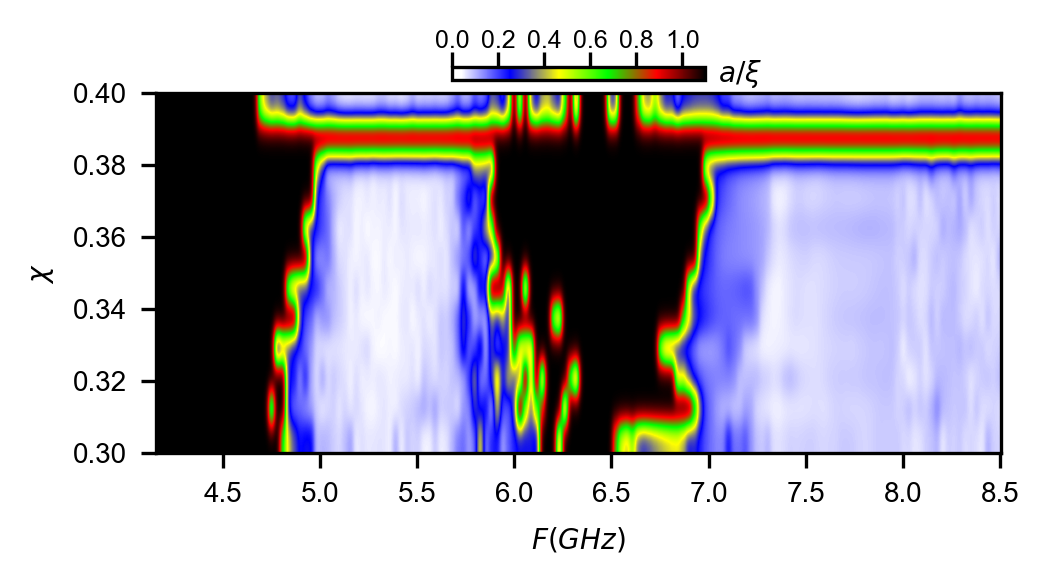

C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\3228167599.py:38: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][6]}$",color="#0f084b")


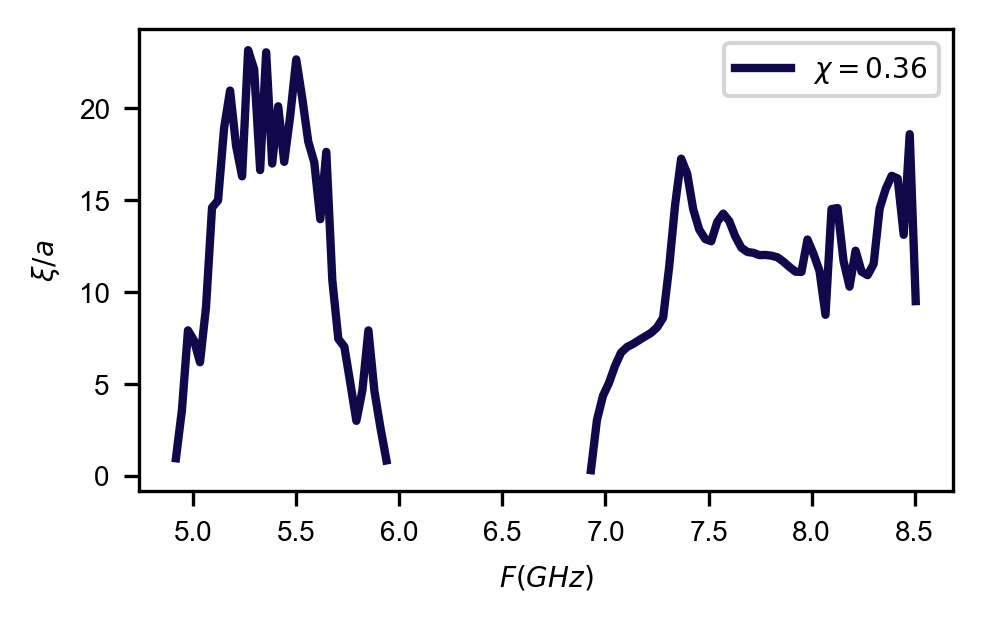

In [14]:
from matplotlib.ticker import MultipleLocator

C_mm = 3e11

# f = data_intensities_exit["f"]/td.C_0
f=C_mm/((td.C_0/data_intensities_exit["f"]) * 15.873)*1e-9
k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    print(h)
    if length not in [7]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
    value = np.copy(average_xis_exit_1[:,h,:])
    value[value >1]=1.1
    value[value == 0]=1.1
    im=ax.imshow(value, vmin = np.min(value), vmax = np.max(value), 
                     extent =[np.min(f),np.max(f), 0.3,0.4], 
                        origin ='lower', cmap=cmap,aspect='auto',interpolation="gaussian") 
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
    cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbar.ax.tick_params(labelsize=6,pad=0)
    ax.set_xlabel(rf"$F(GHz)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')

    # plt.title("PR of average intensity")
    plt.tight_layout()
    plt.show()


def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
value = np.copy(average_xis_exit_1[6,h,:])
plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][6]}$",color="#0f084b")

plt.legend()
plt.xlabel(rf"$F(GHz)$")
plt.ylabel(rf"$\xi/a$")
plt.show()


Average IPR 

In [15]:
average_xis_exit_2 = np.zeros(shape=(11,16,150))
data_exit = np.copy(data_intensities_exit["data_field_intensities"])
for i,chi in enumerate(data_exit):
    if i in [0,12]:
        continue
    for j,length in enumerate(chi): 
        xis = []
        for k,sample in enumerate(length):
            max_value = np.max(sample)
            sample_normalized = sample/max_value
            sample_normalized[sample_normalized <= 1e-5]=0
            xis.append(calculate_IPR(sample_normalized,data_intensities_exit["x"]))

        average_xis_exit_2[i-1,j]=1/np.mean(xis,axis=0)

average_xis_exit_2[np.isnan(average_xis_exit_2)] = 0
average_xis_exit_2[np.isinf(average_xis_exit_2)] = 0

C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\341385272.py:6: RuntimeWarning: invalid value encountered in divide
  return integral_2/integral_1
C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\2060281355.py:10: RuntimeWarning: invalid value encountered in divide
  sample_normalized = sample/max_value


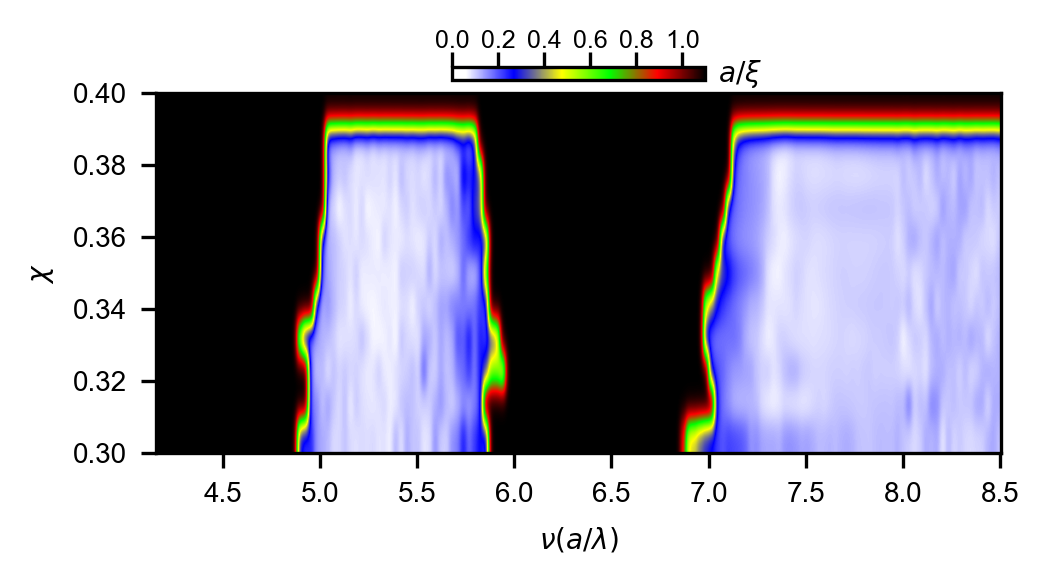

C:\Users\HernandF\AppData\Local\Temp\ipykernel_26240\2971255536.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][6]}$",color="#0f084b")


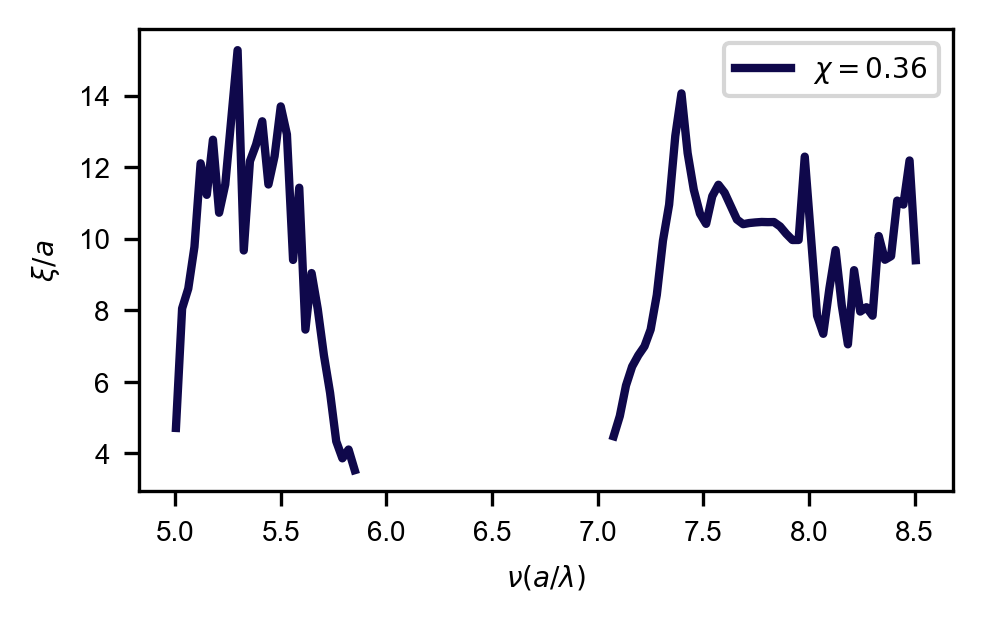

In [16]:
from matplotlib.ticker import MultipleLocator


k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    if length not in [7]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
    value = np.copy(average_xis_exit_2[:,h,:])
    value[value >1]=1.1
    value[value == 0]=1.1
    im=ax.imshow(value, vmin = np.min(value), vmax = np.max(value), 
                     extent =[np.min(f),np.max(f), 0.3,0.4], 
                        origin ='lower', cmap=cmap,aspect='auto',interpolation="gaussian") 
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
    cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbar.ax.tick_params(labelsize=6,pad=0)
    ax.set_xlabel(rf"$\nu(a/\lambda)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')

    # plt.title("Average PR of the samples")
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
value = np.copy(average_xis_exit_2[6,h,:])
plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][6]}$",color="#0f084b")

plt.legend()
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"$\xi/a$")
plt.show()
